In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
nkg = pd.read_csv (r"C:\Users\adm\STAT3013\NKG Historical Data.csv")

In [9]:
nkg = nkg.sort_index(ascending=False)
nkg = nkg.reset_index(drop=True)

# Modify data
# Remove the '%' sign and convert to float
nkg['Change %'] = nkg['Change %'].replace('%', '', regex=True).astype(float)

# Convert the percentage values to decimals (divide by 100)
nkg['Change %'] = nkg['Change %'] / 100

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    nkg[col] = nkg[col].astype(str).str.replace(',', '').astype(float)

nkg['Date'] = pd.to_datetime(nkg['Date'])
nkg

missing_values = nkg.isnull().sum()
nkg = nkg.dropna()

# Function to convert 'K' values to integers
def convert_volume(value):
    if pd.isnull(value):
        return np.nan  # Handle missing values
    elif 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1000000000
    else:
        return float(value)

# Apply the function to the "Volume" column
nkg['Vol.'] = nkg['Vol.'].apply(convert_volume)

# Display the cleaned DataFrame without "Date" column
nkg.drop('Date', axis=1).describe()

,Price,Open,High,Low,Vol.,Change %
count,1207.000000,1207.000000,1207.000000,1207.000000,1.207000e+03,1207.000000
mean,18655.116321,18664.664209,19051.482850,18284.328666,7.665096e+06,0.001785
std,9467.876019,9489.734303,9667.173368,9291.937381,4.778653e+06,0.031644
min,2891.100000,2877.900000,3088.200000,2877.900000,1.661600e+05,-0.070000
25%,11311.850000,11247.250000,11790.700000,10993.450000,4.305000e+06,-0.013850
50%,19350.000000,19350.000000,19800.000000,19050.000000,6.970000e+06,0.001200
75%,24070.850000,24095.850000,24500.000000,23800.000000,1.009500e+07,0.018950
max,44965.800000,45046.300000,45448.500000,44241.900000,2.922000e+07,0.070000


In [13]:
# Tính sai phân
nkg['Price_diff'] = nkg['Price'].diff()

# Loại bỏ các giá trị NaN hoặc Inf trong 'Price_diff'
nkg = nkg.dropna(subset=['Price_diff'])  # Loại bỏ NaN
nkg = nkg[~nkg['Price_diff'].isin([np.inf, -np.inf])]  # Loại bỏ Inf và -Inf

# Kiểm tra xem có giá trị NaN hoặc Inf trong 'Price_diff' hay không
print("Checking for missing or infinite values in Price_diff:")
print(f"NaN values: {nkg['Price_diff'].isnull().sum()}")
print(f"Inf values: {np.isinf(nkg['Price_diff']).sum()}")

# Hàm kiểm tra tính dừng với ADF test
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary (p-value < 0.05).")
    else:
        print("The series is not stationary (p-value >= 0.05).")

# Kiểm tra tính dừng của chuỗi 'Price_diff'
print("\nChecking stationarity of Price_diff:")
check_stationarity(nkg['Price_diff'])

# Chuỗi sử dụng cho mô hình ARIMA
target_series = nkg['Price_diff']

# Kiểm tra lại NaN hoặc Inf trong target_series trước khi chia dữ liệu
target_series = target_series.dropna()
target_series = target_series[~target_series.isin([np.inf, -np.inf])]

# Kiểm tra xem có dữ liệu hợp lệ sau khi làm sạch không
print("\nAfter cleaning target series:")
print(f"NaN values: {target_series.isnull().sum()}")
print(f"Inf values: {np.isinf(target_series).sum()}")

# Tiến hành chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(0.8 * len(target_series))
train_data = target_series[:train_size]
test_data = target_series[train_size:]

# In kết quả chia dữ liệu
print("\nTraining Data Size:", len(train_data))
print("Testing Data Size:", len(test_data))


Checking for missing or infinite values in Price_diff:
NaN values: 0
Inf values: 0

Checking stationarity of Price_diff:
ADF Statistic: -7.66998548567888
p-value: 1.6031738513787085e-11
The series is stationary (p-value < 0.05).

After cleaning target series:
NaN values: 0
Inf values: 0

Training Data Size: 964
Testing Data Size: 241


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15227.878, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15251.064, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=15235.293, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15236.570, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=15235.288, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15237.919, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=15206.112, Time=0.98 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=15239.088, Time=0.23 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=15198.217, Time=1.08 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=15233.283, Time=0.26 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=15217.191, Time=0.75 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=15203.491, Time=1.22 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=15227.888, Time=1.26 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=15215.436, Time=0.41 sec
 ARIMA(5,0,3)(0,0,0

C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


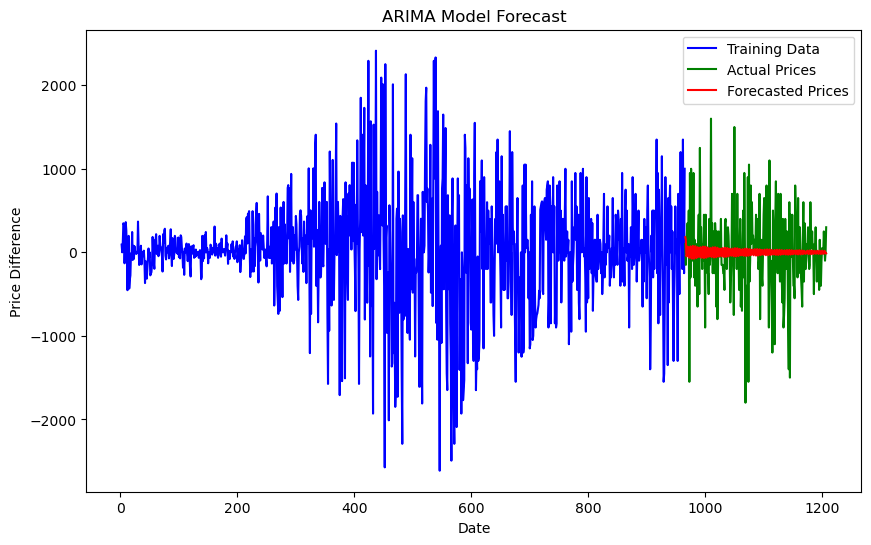


Forecasted vs Actual Prices:
      Actual  Forecasted
966    100.0  -48.467491
967   -150.0  -31.363225
968    150.0   67.800375
969    250.0   58.336797
970    350.0  -52.515208
...      ...         ...
1203   250.0  -15.484262
1204    50.0  -12.708649
1205  -100.0         NaN
1206     0.0         NaN
1207   300.0         NaN

[241 rows x 2 columns]


In [15]:
# Mô hình ARIMA
model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)

# Dự báo trên tập kiểm tra (test_data)
forecast = model.predict(n_periods=len(test_data))  # Đảm bảo rằng số bước dự báo trùng với kích thước test_data

# Kiểm tra kích thước của dự báo
print(f"Forecast length: {len(forecast)}")
print(f"Test data length: {len(test_data)}")

# Tính sai số dự báo (MSE)
mse = mean_squared_error(test_data, forecast)
print("\nMean Squared Error:", mse)

# Vẽ biểu đồ dự báo và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Prices', color='green')
plt.plot(test_data.index, forecast, label='Forecasted Prices', color='red')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.show()

# Lưu kết quả dự báo
forecast_df = pd.DataFrame({'Actual': test_data, 'Forecasted': forecast}, index=test_data.index)
print("\nForecasted vs Actual Prices:")
print(forecast_df)

In [17]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

forecast_diff = model.predict(n_periods=len(test_data))  # Dự báo sai phân (Price_diff)

# Tính giá trị dự báo cuối cùng của Price bằng cách cộng dồn sai phân vào giá cuối cùng của tập huấn luyện
last_price = train_data.iloc[-1]  # Giá cuối cùng của tập huấn luyện (giá gốc)

# Cộng dồn sai phân dự báo vào giá cuối cùng của tập huấn luyện để có giá trị dự báo cho Price
forecast_price = last_price + np.cumsum(forecast_diff)

# Lấy giá trị thực tế (Price) từ test_data
y_actual = nkg['Price'][train_size:].values


# Kiểm tra lại kích thước của hai chuỗi
if len(y_actual) != len(forecast_price):
    print("Dữ liệu thực tế và dự báo không cùng kích thước!")
else:
    # Tính toán các chỉ số đánh giá
    rmse = np.sqrt(mean_squared_error(y_actual, forecast_price))
    print("RMSE:", rmse)

    mape = mean_absolute_percentage_error(y_actual, forecast_price)
    print("MAPE:", mape, "%")

    mae = mean_absolute_error(y_actual, forecast_price)
    print("MAE:", mae)

    r_squared = r2_score(y_actual, forecast_price)
    print("R-squared (Using sklearn):", r_squared)


RMSE: 22199.416225930378
MAPE: 0.9435056106060168 %
MAE: 22135.44448014212
R-squared (Using sklearn): -172.64037475111326


C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\adm\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
